# Learning

In [1]:
from hmm.hmm import HMM
from hmm.learning import hard_assignment_em, learn_parameters_everything_observed
from hmm.types import IntArray

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

In [2]:
gamma = 0.1
beta = 0.2
alpha = 0.9
rates = [1, 5]

res = []

for t in range(5, 400, 2):
    def create_transition_matrix(gamma, beta):
        return np.array(
            [[1 - gamma, 0, gamma], [0, 1 - gamma, gamma], [beta / 2, beta / 2, 1 - beta]]
        )

    transition_matrix = create_transition_matrix(gamma, beta)
    hmm = HMM(transition_matrix, alpha, processing_modes=[0, 1, 2], rates=rates)

    num_nodes = 8
    time_steps = t
    initial_c = 2

    observed_processing_modes, observed_focus, observed_stimuli = hmm.forward(
        num_nodes,
        time_steps,
        initial_c,
    )

    (
        lambda_0_hat,
        lambda_1_hat,
        learned_alpha,
        learned_beta,
        learned_gamma
    ) = learn_parameters_everything_observed(
        observed_processing_modes,
        observed_focus,
        observed_stimuli
    )

    print(f"True alpha: {hmm.alpha:.2}, Learned alpha: {learned_alpha:.2}")
    print(f"True rates: {hmm.rates}, Learned rates: {[lambda_0_hat, lambda_1_hat]}")
    print(f"True beta: {beta:.2}, Learned beta: {learned_beta:.2}")
    print(f"True gamma: {gamma:.2}, Learned gamma: {learned_gamma:.2}")
    print(f"True transition matrix:\n{hmm.transition}")
    print(f"Learned transition matrix:\n{create_transition_matrix(learned_gamma, learned_beta)}")

    absolut = abs(hmm.alpha-learned_alpha) + abs(beta-learned_beta) + abs(gamma-learned_gamma) + abs(hmm.rates[0]-lambda_0_hat) + abs(hmm.rates[1]-lambda_1_hat)
    res.append([t, 
                abs(hmm.alpha-learned_alpha), 
                abs(beta-learned_beta), 
                abs(gamma-learned_gamma), 
                abs(hmm.rates[0]-lambda_0_hat), 
                abs(hmm.rates[1]-lambda_1_hat),
                absolut])

ZeroDivisionError: division by zero

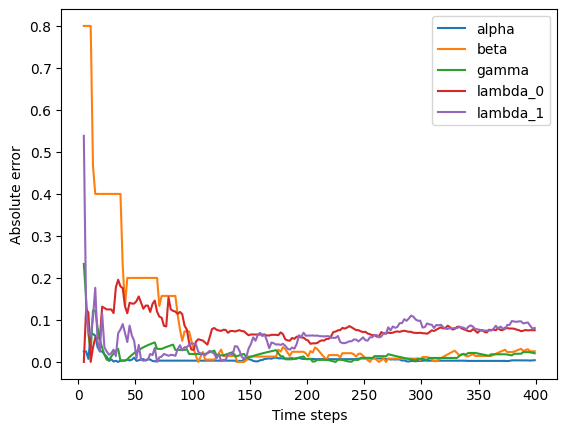

In [ ]:
plt.plot([r[0] for r in res], [r[1] for r in res], label="alpha")
plt.plot([r[0] for r in res], [r[2] for r in res], label="beta")
plt.plot([r[0] for r in res], [r[3] for r in res], label="gamma")
plt.plot([r[0] for r in res], [r[4] for r in res], label="lambda_0")
plt.plot([r[0] for r in res], [r[5] for r in res], label="lambda_1")
plt.xlabel("Time steps")
plt.ylabel("Absolute error")
plt.legend()

In [ ]:
gamma = 0.1
beta = 0.2
alpha = 0.6
rates = [1, 5]

# This is uppercase-gamma.
transition_matrix = np.array(
    [[1 - gamma, 0, gamma], [0, 1 - gamma, gamma], [beta / 2, beta / 2, 1 - beta]]
)

In [ ]:
hmm = HMM(transition_matrix, alpha, processing_modes=[0, 1, 2], rates=rates)

### Simulated data

In [ ]:
num_nodes = 8
time_steps = 1000
initial_c = 2

In [ ]:
observed_processing_modes, observed_focus, observed_stimuli = hmm.forward(
    num_nodes,
    time_steps,
    initial_c,
)

### Learning with everything observed

In [ ]:
# This is necessary for mask computation.
observed_processing_modes: IntArray = np.array(observed_processing_modes)

In [ ]:
(
    lambda_0_hat,
    lambda_1_hat,
    learned_alpha,
    learned_beta,
    learned_gamma
) = learn_parameters_everything_observed(
    observed_processing_modes,
    observed_focus,
    observed_stimuli
)

In [ ]:
observed_focus.shape

(1000, 8)

Learned parameters ...

In [ ]:
learned_rates = [lambda_0_hat, lambda_1_hat]
learned_transition_matrix = np.array(
    [[1 - learned_gamma, 0, learned_gamma],
     [0, 1 - learned_gamma, learned_gamma],
     [learned_beta / 2, learned_beta / 2, 1 - learned_beta]]
)

In [ ]:
learned_hmm = HMM(
    transition=learned_transition_matrix,
    alpha=learned_alpha,
    processing_modes=hmm.processing_modes,
    rates=learned_rates
)

In [ ]:
random_focus = np.random.randn(*observed_focus.shape) > 0.5
random_focus = random_focus.astype(int)

# Den her fejler lidt tilfældigt, så scroll lidt længere ned for at finde en til at debugge

In [ ]:
learned_hmm = hard_assignment_em(observed_stimuli, HMM(transition_matrix, alpha, processing_modes=[0, 1, 2], rates=rates))

/Users/oscarhedeby/Documents/KU/ModComp/hmm/hmm/hmm.py:263: RuntimeWarning: invalid value encountered in divide
  beta_cs[t] /= beta_cs[t].sum()


ZeroDivisionError: division by zero

In [ ]:
print(f"True alpha: {hmm.alpha:.2}, Learned alpha: {learned_hmm.alpha:.2}")
print(f"True rates: {hmm.rates}, Learned rates: {learned_hmm.rates}")
print(f"True beta: {beta:.2}, Learned beta: {learned_beta:.2}")
print(f"True gamma: {gamma:.2}, Learned gamma: {learned_gamma:.2}")
print(f"True transition matrix:\n{hmm.transition}")
print(f"Learned transition matrix:\n{learned_hmm.transition}")

# HEY NIELS 🙋🏿‍♀️🙋🏼‍♂️
Den her gør det nemmere at debugge

In [ ]:
true_processing_modes, true_focus, observations = hmm.forward(
    num_nodes,
    time_steps,
    initial_c,
)

rand_gamma = 0.45 # > 0.5 is bad
rand_beta = 0.4
rand_alpha = 0.56
rand_rates = [1, 5]

# This is uppercase-gamma.
rand_transition_matrix = np.array(
    [[1 - rand_gamma, 0, rand_gamma], [0, 1 - rand_gamma, rand_gamma], [rand_beta / 2, rand_beta / 2, 1 - rand_beta]]
)

h0 = HMM(rand_transition_matrix, rand_alpha, processing_modes=[0, 1, 2], rates=rand_rates)
c_marginals, z_marginals = learned_hmm.nielslief_propagation(observations)
c_argmax = np.argmax(c_marginals, axis=1)
c_diff = abs(c_argmax - true_processing_modes).sum() / (time_steps * 3)

z_argmax = [[z[0] > z[1] for z in z_marg] for z_marg in z_marginals]
z_argmax = np.array(z_argmax).astype(int)
z_diff = abs(z_argmax - true_focus).sum() / (num_nodes * time_steps)

print(f"iteration 0: c_diff={c_diff}, z_diff={z_diff}")

hmms = [(h0, c_diff, z_diff)]

for i in range(10):
    learned_hmm = hard_assignment_em(observations, HMM(rand_transition_matrix, rand_alpha, processing_modes=[0, 1, 2], rates=rand_rates), max_iterations=i)
    c_marginals, z_marginals = learned_hmm.nielslief_propagation(observations)
    c_argmax = np.argmax(c_marginals, axis=1)        
    c_diff = abs(c_argmax - true_processing_modes).sum() / (time_steps*3)

    z_argmax = [[z[0] > z[1] for z in z_marg] for z_marg in z_marginals]
    z_argmax = np.array(z_argmax).astype(int)
    z_diff = abs(z_argmax - true_focus).sum() / (num_nodes * time_steps)
    
    hmms.append((learned_hmm, c_diff, z_diff))
    print(f"iteration {i}: c_diff={c_diff}, z_diff={z_diff}")

iteration 0: c_diff=0.37366666666666665, z_diff=0.521375
iteration 0: c_diff=0.3436666666666667, z_diff=0.521375
iteration 1: c_diff=0.37366666666666665, z_diff=0.521375
iteration 2: c_diff=0.37366666666666665, z_diff=0.521375
Found good after 2 iterations!
iteration 3: c_diff=0.37366666666666665, z_diff=0.521375
Found good after 2 iterations!
iteration 4: c_diff=0.37366666666666665, z_diff=0.521375
Found good after 2 iterations!
iteration 5: c_diff=0.37366666666666665, z_diff=0.521375
Found good after 2 iterations!
iteration 6: c_diff=0.37366666666666665, z_diff=0.521375
Found good after 2 iterations!
iteration 7: c_diff=0.37366666666666665, z_diff=0.521375
Found good after 2 iterations!
iteration 8: c_diff=0.37366666666666665, z_diff=0.521375
Found good after 2 iterations!
iteration 9: c_diff=0.37366666666666665, z_diff=0.521375


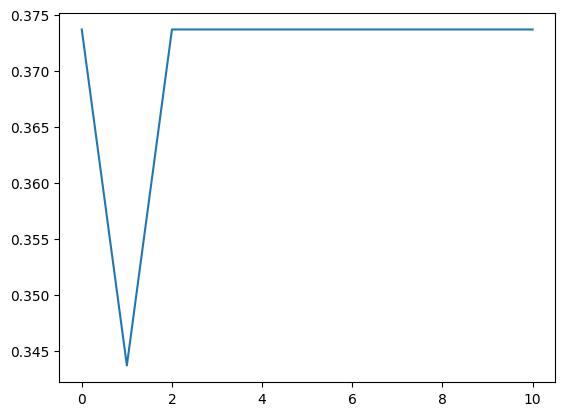

In [ ]:
plt.plot([hmm[1] for hmm in hmms])
plt.show()

### Testing the learned model (everything observed)

In [ ]:
true_processing_modes, true_focus, observations = hmm.forward(
    num_nodes,
    time_steps,
    initial_c,
)

In [ ]:
original_marginals_c, original_marginals_z = hmm.nielslief_propagation(observations)
learned_marginals_c, learned_marginals_z = learned_hmm.nielslief_propagation(observations)

In [ ]:
original_marginals_c, original_marginals_z = hmm.nielslief_propagation(observations)
learned_marginals_c, learned_marginals_z = learned_hmm.nielslief_propagation(observations)

In [ ]:
def check_correctness(marginals_c, marginals_z, hmm_to_use) -> None:
    estimated_C = np.argmax(marginals_c, axis=1)
    # Compute the most likely Z given the estimated C
    estimated_Z = np.zeros((time_steps, num_nodes), dtype=int)

    for t, c in enumerate(estimated_C):
        estimated_Z[t] = hmm_to_use.sample_hidden_z(num_nodes, c)

    correct_C = np.sum(np.equal(estimated_C, true_processing_modes)) / (time_steps - 1)
    correct_Z = np.sum(true_focus == estimated_Z) / (time_steps * num_nodes)

    print(f"Proportion of correct C estimations: {correct_C:.2f}")
    print(f"Proportion of correct Z estimations: {correct_Z:.2f}")

In [ ]:
check_correctness(original_marginals_c, original_marginals_z, hmm)
check_correctness(learned_marginals_c, learned_marginals_z, learned_hmm)

In [ ]:
training_data = np.genfromtxt("../../data/Ex_1.csv", delimiter="," ,dtype=int)[1:, 1:]

original_marginals_c, original_marginals_z = hmm.nielslief_propagation(training_data)

check_correctness(original_marginals_c, original_marginals_z, learned_hmm)

## Learning just from $\textbf{X}$ (full learning)

Compute $\hat{Z}_{t,i} = \argmax_z P(Z_{t,i} = z | \textbf{X} = \textbf{x})$ and $\hat{C}_t = \argmax_z P(C_t = z | \textbf{X} = \textbf{x})$

In [ ]:
# Whatever. We're just using some joint-prob, taking from above. :)
z_hat, c_hat = hmm.nielslief_propagation(training_data)

In [ ]:
c_hat

Learning ...

In [ ]:
epochs: int = 10 # lol.

In [ ]:
hmm = HMM(transition_matrix, alpha, processing_modes=[0, 1, 2], rates=rates)

In [ ]:
for _ in range(epochs):
    joint_prob = hmm.infer(observations)
    z_hat, c_hat = expectation_maximisation_hard_assignment(joint_prob, num_nodes=num_nodes)

    (
        lambda_0_hat,
        lambda_1_hat,
        learned_alpha,
        learned_beta,
        learned_gamma
    ) = learn_parameters_everything_observed(
        c_hat,
        z_hat,
        observations[:-1]
    )

    learned_rates = [lambda_0_hat, lambda_1_hat]
    learned_transition_matrix = np.array(
        [[1 - learned_gamma, 0, learned_gamma],
        [0, 1 - learned_gamma, learned_gamma],
        [learned_beta / 2, learned_beta / 2, 1 - learned_beta]]
    )

    hmm = HMM(learned_transition_matrix, alpha=learned_alpha, processing_modes=hmm.states, rates=learned_rates)


In [ ]:
learned_joint_prob = hmm.infer(observations)

In [ ]:
marginal_prob_C = np.sum(learned_joint_prob, axis=2)

estimated_C = np.argmax(marginal_prob_C, axis=1)
estimated_Z = np.zeros((time_steps, num_nodes), dtype=int)

for t, c in enumerate(estimated_C):
    estimated_Z[t] = hmm.sample_hidden_z(num_nodes, c)

correct_C = np.sum(np.equal(estimated_C, true_processing_modes[:-1])) / (time_steps - 1)
correct_Z = np.sum(estimated_Z == true_focus) / ((time_steps - 1) * num_nodes)

print(f"Proportion of correct C estimations: {correct_C:.2f}")
print(f"Proportion of correct Z estimations: {correct_Z:.2f}")